# Import libaries and load/Inspect Data

In [133]:
# Core Data Analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Crypto data
import yfinance as yf

In [134]:
# CYBERPUNK THEMED CHARTS
plt.style.use('dark_background')

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.facecolor': 'black',
    'axes.edgecolor': 'magenta',
    'axes.labelcolor': 'white',
    'axes.titlesize': 15,
    'axes.titlepad': 12,
    'axes.grid': True,
    'grid.color': 'cyan',
    'grid.alpha': 0.2,
    'lines.linewidth': 2.5,
    'lines.color': '#00FFFF',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'legend.facecolor': '#1a1a1a',
    'legend.edgecolor': 'magenta',
    'figure.facecolor': 'black',
    'font.size': 12
})

In [135]:
# Load in daily close prices and rename as price
eth = yf.download('ETH-USD', start='2021-06-01', interval='1d')[['Close']]
eth.rename(columns={"Close": "price"}, inplace=True)
eth.dropna(inplace=True)
eth.tail()

C:\Users\User\AppData\Local\Temp\ipykernel_14600\1725726573.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download('ETH-USD', start='2021-06-01', interval='1d')[['Close']]
[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,ETH-USD
Date,
2025-10-27,4120.122070
2025-10-28,3982.262451
2025-10-29,3903.353027
2025-10-30,3804.375244
2025-11-01,3863.304932


In [136]:
# Check basic statistics
eth.describe()

Price,price
Ticker,ETH-USD
count,1614.000000
mean,2561.230881
std,921.389778
min,993.636780
25%,1800.868103
50%,2473.997803
75%,3274.829712
max,4831.348633


In [137]:
# Check for nulls and data types
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1614 entries, 2021-06-01 to 2025-11-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (price, ETH-USD)  1614 non-null   float64
dtypes: float64(1)
memory usage: 25.2 KB


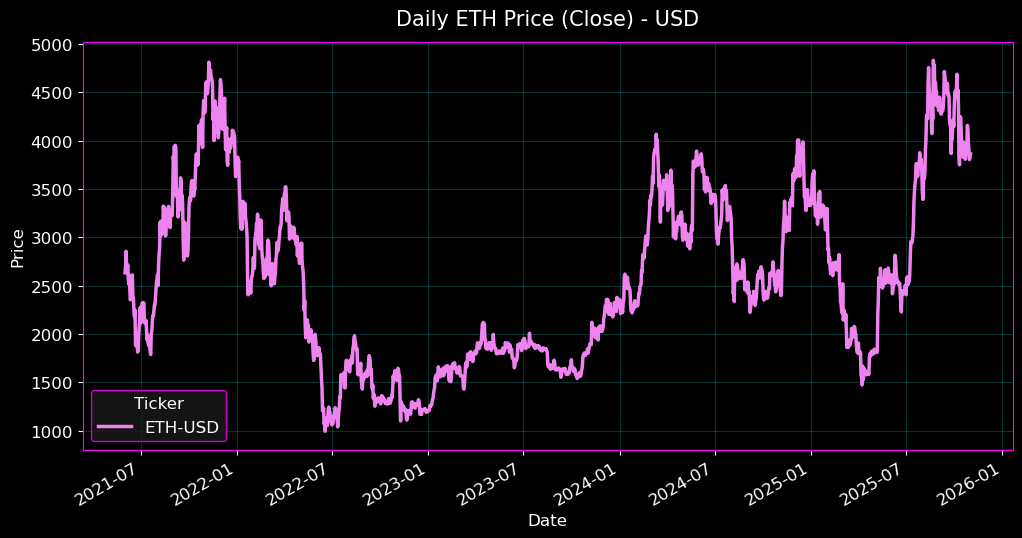

In [138]:
# Plot ETH price over time
eth['price'].plot(title='Daily ETH Price (Close) - USD', color='violet', legend=True)
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [139]:
# Log transform to handle percentage changes and handle variance
eth['log_price'] = np.log(eth['price'])

# Checking for stationarity/Transformations

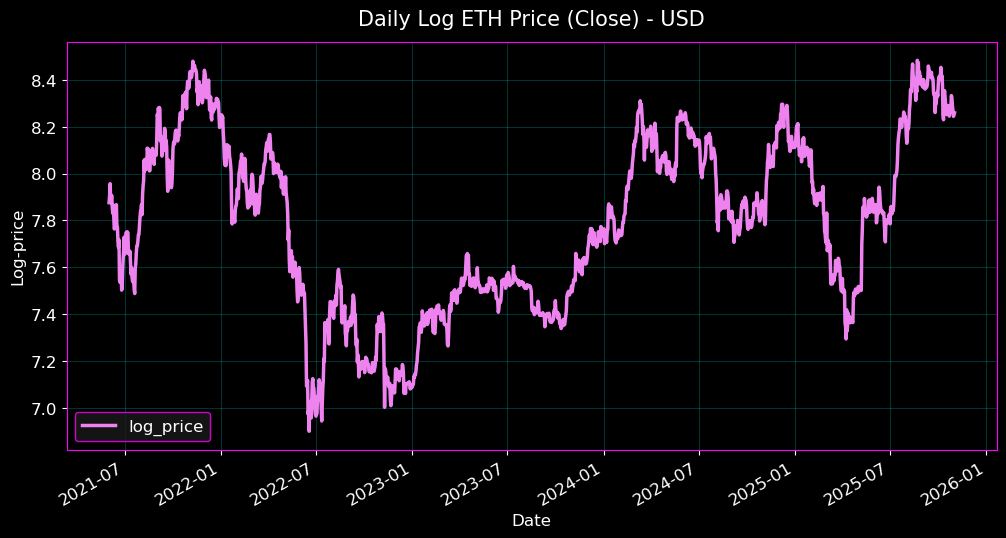

In [140]:
# Plot log transformed price over time
eth['log_price'].plot(title='Daily Log ETH Price (Close) - USD', color='violet', legend=True)
plt.xlabel('Date')
plt.ylabel('Log-price')
plt.show()

Mean is unconstant, however variance seems so have settled a bit from the log-transformation. Log transformation stabilizes variance and converts multiplicative price changes into additive ones to better fit ARIMA's linear assumptions. 

In [141]:
# Run ADF test to check stationarity
results = adfuller(eth['log_price'])
print(f'ADF Statistic: {results[0]: .4f}')
print(f'P-value: {results[1]: .4f}')
for key, value in results[4].items():
    print(f"Critical Value ({key}): {value: .4f}")
print('-' * 160)
if results[1] > 0.05:
    print("The P-Value is above the 0.05 threshold, we fail to reject the null hypothesis and conclude that there is a unit root "
          "and the data is nonstationary,\n differencing might be needed(nonstationary).")
else:
    print('The P-Value falls below the 0.05 threshold, we reject the null hypthesis and conclude there are no unit roots (stationary)')

ADF Statistic: -1.8540
P-value:  0.3540
Critical Value (1%): -3.4344
Critical Value (5%): -2.8633
Critical Value (10%): -2.5677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
The P-Value is above the 0.05 threshold, we fail to reject the null hypothesis and conclude that there is a unit root and the data is nonstationary,
 differencing might be needed(nonstationary).


# For the Augmented Dickey-Fuller test, the P-Value is above the 0.05 threshold, we do not reject the null hypothesis and conclude that there is a unit root and the data is nonstationary, differencing might be needed. The ADF statistic is greater than the crtitical values at the 1%, 5%, and 10% significance levels.

In [142]:
# Difference and drop the first observation that got turned into a NULL from differencing
eth['diff_log_price'] = eth['log_price'].diff()
eth.dropna(inplace=True)

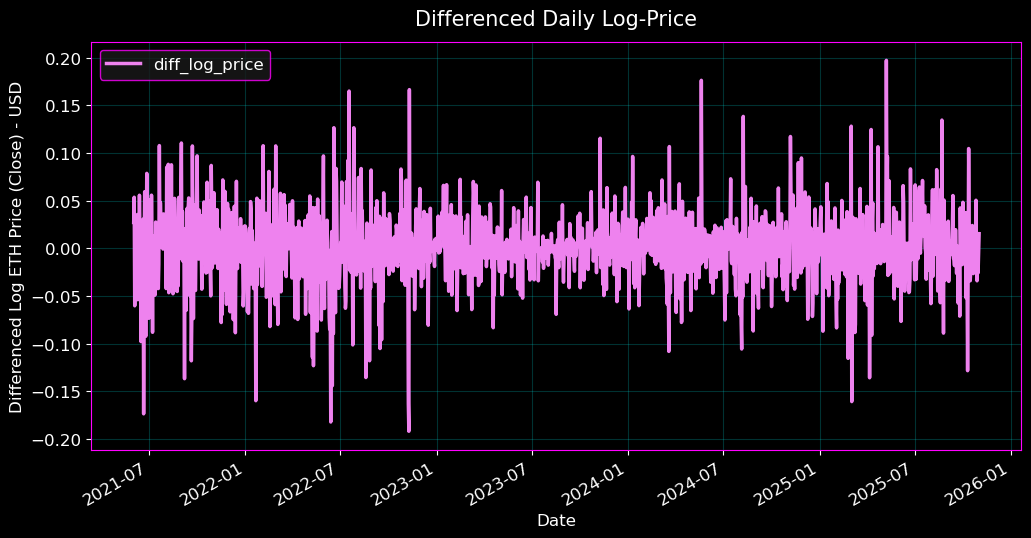

In [143]:
# Check mean of differenced Log Price
eth['diff_log_price'].plot(title='Differenced Daily Log-Price', color='violet', legend=True)
plt.xlabel('Date')
plt.ylabel('Differenced Log ETH Price (Close) - USD')
plt.show()

In [144]:
# Run ADF test to check stationarity
results = adfuller(eth['diff_log_price'])
print(f'ADF Statistic: {results[0]: .4f}')
print(f'P-value: {results[1]: .4f}')
for key, value in results[4].items():
    print(f"Critical Value ({key}): {value: .4f}")
print('-' * 160)
if results[1] > 0.05:
    print("The P-Value is above the 0.05 threshold, we fail to reject the null hypothesis and conclude that there is a unit root "
          "and the data is nonstationary,\n differencing might be needed(nonstationary).")
else:
    print('The P-Value falls below the 0.05 threshold, we reject the null hypthesis and conclude there are no unit roots (stationary)')

ADF Statistic: -41.0477
P-value:  0.0000
Critical Value (1%): -3.4344
Critical Value (5%): -2.8633
Critical Value (10%): -2.5677
----------------------------------------------------------------------------------------------------------------------------------------------------------------
The P-Value falls below the 0.05 threshold, we reject the null hypthesis and conclude there are no unit roots (stationary)


# After differencing, the mean seems to have stabilized and settled around 0 and is ready for model selection testing.

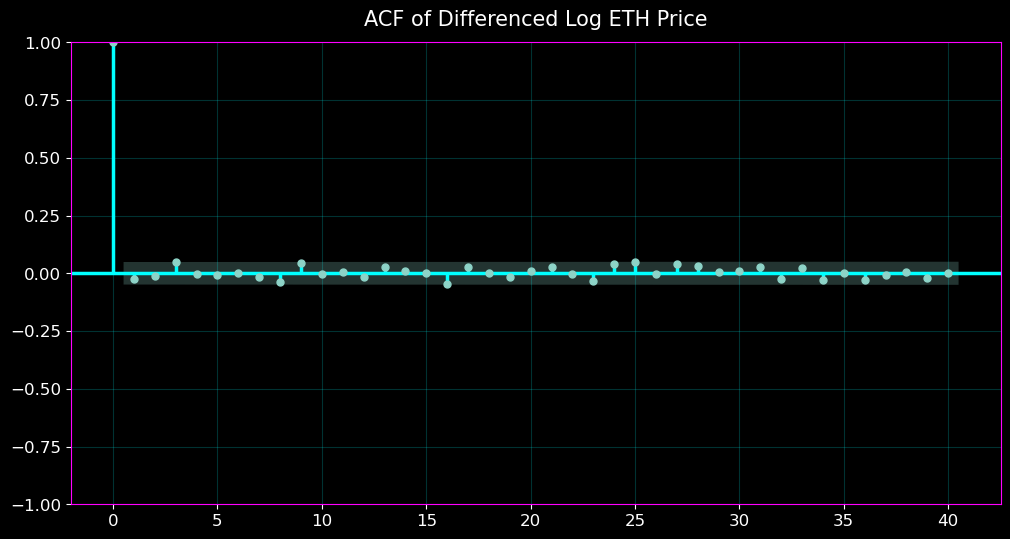

In [152]:
plot_acf(eth['diff_log_price'], lags=40)
plt.title('ACF of Differenced Log ETH Price')
plt.show()

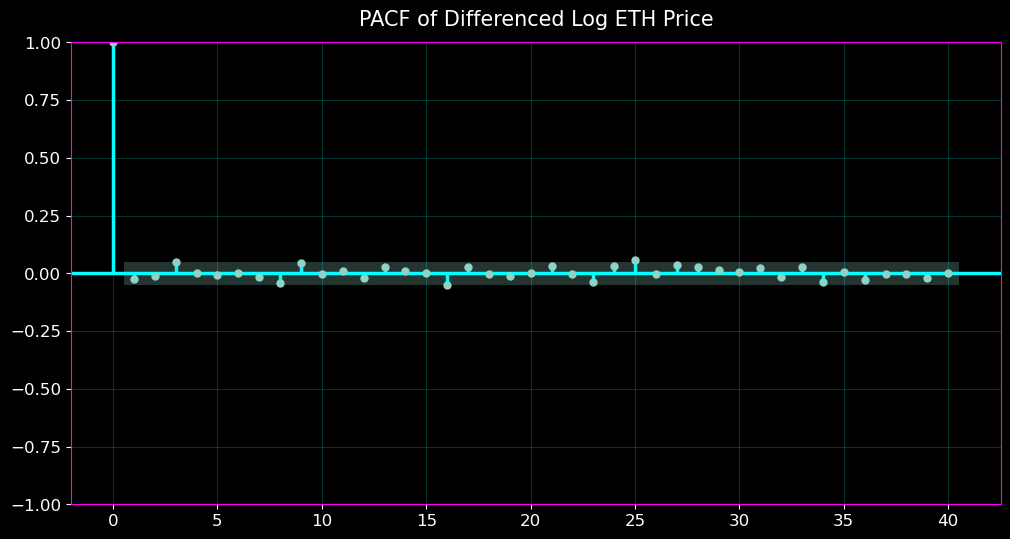

In [153]:
plot_pacf(eth['diff_log_price'], lags=40)
plt.title('PACF of Differenced Log ETH Price')
plt.show()

Both the PACF and ACF die out after the single spike at lag 0, the differencing seems to have removed most of the structure from the process making it similar to white noise and limiting ARIMA's linear predictability, ultimately the model will end up reducing to ARIMA(0, 1, 0) - A random walk or some low order ARIMA model. We can use an ARIMA(0,1,0) as a baseline model to compare to GARCH, LSTM or transformer models, which will be able to model this better.